In [1]:
##############################
#
# 09/03/18 setup
#
##############################
from __future__ import division
%matplotlib inline
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy import array
import pandas as pd
import sklearn
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import random

# set random seed
# We need to set the cudnn to derministic mode so that we can get consistent result
# Yet, this will slow down the training :( It's a trade-off
# see https://discuss.pytorch.org/t/how-to-confugure-pytorch-to-get-deterministic-results/11797
# see https://discuss.pytorch.org/t/network-forward-backward-calculation-precision-error/17716/2
random_state = 100
np.random.seed(random_state)
torch.manual_seed(random_state)
random.seed(random_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# parameters
data_root_dir = '/Users/janaki/Dropbox/bci/bill_grant_Fall2018'
f_name = 'data1_nn_time.csv'

# load the feature and data
df = pd.read_csv('%s/%s' %(data_root_dir, f_name), header=-1)

# define label and feature; convert it to ndarray
# adjust the label from 0 to 9
# y does not have to be one-hot embedding, i.e., if 10 class, then dim is 1000x10, can be 1000,
df_label = df.iloc[:,0]
df_f = df.iloc[:,1:]
X1 = df_f.as_matrix()
y1 = df_label.as_matrix() 
print(y1.shape)
print(X1.shape)

(12375,)
(12375, 89)


In [4]:
X_raw = np.zeros((225,55,89))
for i in np.arange(89):
    X_raw[:,:,i] = np.reshape(X1[:,i],(55,225)).transpose()
    assert np.all(X_raw[:,0,i] == X1[0:225,i])
y = np.reshape(y1,(55,225)).transpose()
s = np.arange(X_raw.shape[1])
np.random.shuffle(s)
X_train = X_raw[:,s[0:44],:]
X_val = X_raw[:,s[44:50],:]
X_test = X_raw[:,s[50:55],:]
print(X_raw.shape)
print(X_val.shape)

#assert np.all(torch.tensor(y,dtype = torch.long).contiguous().view(225*123) == torch.tensor(y1,dtype = torch.long).contiguous().view(225*123))

(225, 55, 89)
(225, 6, 89)


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(89, 64)
        self.fc2 = nn.Linear(64, 89)
        self.tanh = nn.Tanh()

    def forward(self, x):
        encode_x = self.tanh(self.fc1(x))
        recon_x = self.tanh(self.fc2(encode_x))
        return encode_x, recon_x

In [6]:
def loss_function(recon_x, x):
    BCE = F.mse_loss(recon_x, x.view(-1, 89))

    return BCE

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    for i in np.arange(X_train.shape[1]):
        data = X_train[:,i,:]
        data = torch.tensor(data, device=device)
        optimizer.zero_grad()
        _, recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss

In [8]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i in np.arange(X_val.shape[1]):
            #import pdb; pdb.set_trace()
            data = X_val[:,i,:]
            data = torch.tensor(data, device=device)
            _, recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()
    return test_loss       

In [9]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
# define the data
X_train = X_train.astype(np.float32) 
X_val = X_val.astype(np.float32) 
training_loss = []
validation_loss = []

for epoch in range(0,70):
    tr_loss = train(epoch)
    training_loss.append(tr_loss/44)
    val_loss = test(epoch)
    validation_loss.append(val_loss/6)

In [11]:
X_raw = X_raw.astype(np.float32) 
X_raw_new = np.zeros([225,55,64])
for i in np.arange(X_raw.shape[1]):
    data = X_raw[:,i,:]
    data = torch.tensor(data, device=device)
    feature,_ = model(data)
    X_raw_new[:,i,:] = feature.detach().numpy()

(225, 55, 64)

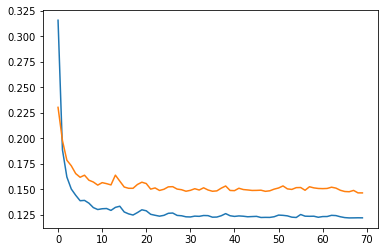

In [15]:
plt.plot(training_loss)
plt.plot(validation_loss)
X_raw_new.shape

X_raw_new then becomes the new input to the rnn_batch_bidirectional file. 